In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
import numpy as np
import random
import seaborn as sns

from script_Collateralized_Auction_genetic import num_advertisers, num_auctions

In [13]:
# Load the data
with open('ga_results1.pkl', 'rb') as f:
    data = pkl.load(f)
    
print(len(data))
print(data[0])

27
{'externality_cost_per_impression': 0.001, 'num_advertisers': 20, 'num_auctions': 500, 'random_seed': 7028124, 'k': 1, 'polynomial_degree': 1, 'tau': [np.float64(-288.0240463647211), np.float64(-3.9078602086682244)], 'w_vcg_adv': np.float64(189472.4421302483), 'w_coll_adv': np.float64(189309.76647158258), 'w_vcg_ext': np.float64(-5820.444387769576), 'w_coll_ext': np.float64(-5526.579421367701), 'w_vcg_tot': np.float64(183651.9977424787), 'w_coll_tot': np.float64(183783.18705021488)}


In [3]:
# Create a dataframe
df = pd.DataFrame.from_records(data, index=range(len(data)))
df.head()

,externality_cost_per_impression,num_advertisers,num_auctions,random_seed,k,polynomial_degree,replication,tau,w_vcg_adv,w_coll_adv,w_vcg_ext,w_coll_ext,w_vcg_tot,w_coll_tot
0,0.0010,20,500,7028124,1,1,1,"[-288.0240463647211, -3.9078602086682244]",189472.442130,189309.766472,-5820.444388,-5526.579421,183651.997742,183783.187050
1,0.0010,20,500,18044072,1,1,2,"[-295311.66815782717, -10.531690407266321]",188499.497463,188499.497463,-5.779317,-5.779317,188493.718146,188493.718146
2,0.0050,20,500,117185409,1,1,1,"[-112667.40872516247, -0.7559833099006132]",183207.264319,183207.264319,-0.028786,-0.028786,183207.235534,183207.235534
3,0.0050,20,500,39207276,1,1,2,"[-6065.75430780409, -60.195898351445194]",179068.110863,179068.110863,-0.000141,-0.000141,179068.110722,179068.110722
4,0.0075,20,500,42178968,1,1,1,"[-0.9364296809787012, -13.452615017038578]",183306.976462,183306.976462,-0.000001,-0.000001,183306.976461,183306.976461


In [15]:
print([d['w_vcg_ext'] for d in data])

[np.float64(-5820.444387769576), np.float64(-28.896586112057864), np.float64(-0.2158943568315873), np.float64(-0.002120304640468688), np.float64(-5.06682509665007e-05), np.float64(-3.1179531763872944e-06), np.float64(-2.77210408775852e-07), np.float64(-1.3195516509148862e-07), np.float64(-1.5128910912385263e-07), np.float64(-1.304660061895734e-10), np.float64(-6.636089031218473e-13), np.float64(-5.137230942752443e-15), np.float64(-5.782486756589223e-17), np.float64(-1.2721005116357497e-18), np.float64(-6.256336254375515e-20), np.float64(-6.241100500815301e-21), np.float64(-3.411126763557234e-21), np.float64(-2.9296155519460503e-21), np.float64(-3.2834097341878467e-24), np.float64(-1.6756595168266482e-26), np.float64(-1.2295773620048474e-28), np.float64(-1.1398110447177188e-30), np.float64(-3.147772250409032e-32), np.float64(-1.5836328757042838e-33), np.float64(-1.5926230321675891e-34), np.float64(-8.35871428438695e-35), np.float64(-7.807712230328754e-35)]


In [16]:
tweet_data = pd.read_csv('full_tweets.csv')

print(tweet_data[['externality_cpm', 'action_count_per_1000_impressions']].describe())


tweet_data['created_at_dt'] = pd.to_datetime(tweet_data['created_at'])
date_pulled = pd.to_datetime('02/02/2025')
tweet_data['days_old'] = (date_pulled - tweet_data['created_at_dt']).dt.days
tweet_data['months_old'] = tweet_data['days_old'] / 30

tweet_data['impressions_per_month'] = tweet_data['impression_count'] / (tweet_data['months_old'])

# user per month
externality_cost_per_impression = 0.00153

externality_max = tweet_data['externality'].abs().max()
tweet_data['ext_dollars_per_month'] = ((tweet_data['externality'] / externality_max) *
                                       tweet_data['impressions_per_month'] *
                                       externality_cost_per_impression)
tweet_data['ext_per_month'] = ((tweet_data['externality'] / externality_max) *
                               tweet_data['impressions_per_month'])

# producer actions per month
tweet_data['action_per_month'] = tweet_data['action_count'] / tweet_data['months_old']

       externality_cpm  action_count_per_1000_impressions
count     11853.000000                       11853.000000
mean         -0.795309                           7.261223
std           0.412564                           8.994813
min          -1.530000                           0.000450
25%          -1.122226                           1.650213
50%          -0.712418                           4.360297
75%          -0.456341                           9.392109
max           0.176109                         125.404512


Best line found: y = -6065.754308 + -60.195898*x^1
Random Seed: 39207276


C:\Users\gabem\AppData\Local\Temp\ipykernel_33636\4007252355.py:39: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


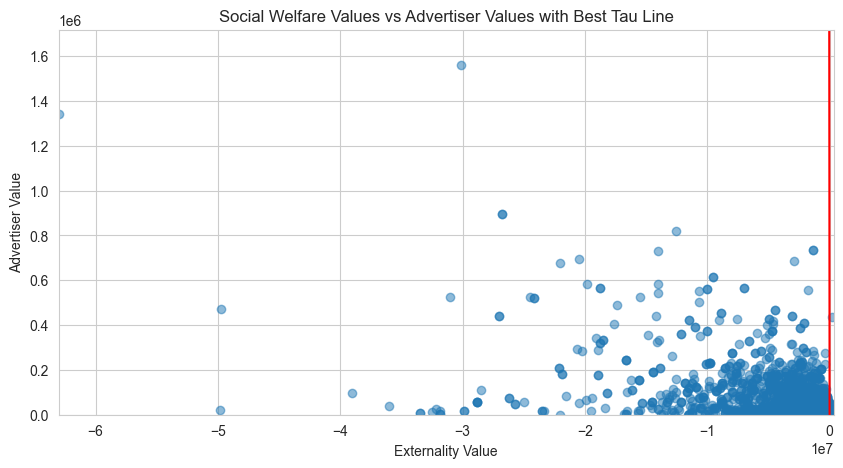

In [28]:
def ad_distribution(data, num_advertisers, rng):
    sample = data.sample(n=num_advertisers, random_state=rng)
    advertisers = [(row['v'], row['e']) for index, row in sample.iterrows()]
    # v = rng.choice(average_ad_costs, 1, p=ad_cost_probabilities) * tweet_data['action_count_per_1000_impressions'].iloc[random_i]
    # e = tweet_data['externality_cpm'][random_i]
    return advertisers

def tau(e, coeffs):
    tau_val = 0
    for i, coeff in enumerate(coeffs):
        tau_val += coeff * (e**i)
    return tau_val

def plot_advertisers(auction_output, ad_scaler=1, ext_scaler=1):
    # plot all advertisers and best line
    advertisers = auction_output['advertisers']
    tau_coeffs = auction_output['tau']
    v = [ad[0]*ad_scaler for advertisers_set in advertisers for ad in advertisers_set]
    e = [ad[1]*ext_scaler for advertisers_set in advertisers for ad in advertisers_set]
    min_e, max_e = min(e), max(e)*1.1
    division_size = int(((2*max_e) - min_e) / 100)
    tau_x = [min_e + i*division_size for i in range(100)]
    tau_y = [tau(t, tau_coeffs) for t in tau_x]
    # tau_min = sum([tau_coeffs[i]*(min_e**i) for i in range(len(tau_coeffs))])
    # tau_max = sum([tau_coeffs[i]*(max_e**i) for i in range(len(tau_coeffs))])
    
    # %matplotlib notebook
    fig, axs = plt.subplots(1, 1, figsize=(10, 5))
    
    axs.scatter(e, v, alpha=0.5)
    axs.plot(tau_x, tau_y, color='red')
    axs.set_ylabel('Advertiser Value')
    axs.set_xlabel('Externality Value')
    axs.set_title('Social Welfare Values vs Advertiser Values with Best Tau Line')
    
    # set x and y limits
    axs.set_xlim(min_e, max_e)
    axs.set_ylim(0, max(v)*1.1)
    fig.show()

tweet_data['v'] = tweet_data['action_per_month']
tweet_data['e'] = tweet_data['ext_per_month']

for d in data:
    if d['polynomial_degree'] == 1 and d['externality_cost_per_impression'] == 0.01:
        polynomial_string = ' + '.join([f'{c:.6f}*x^{i}' if i != 0 else f'{c:.6f}' for i, c in enumerate(d['tau'])])
        print(f"Best line found: y = {polynomial_string}")
        print(f"Random Seed: {d['random_seed']}")
        
        random_seed = d['random_seed']
        num_advertisers = d['num_advertisers']
        num_auctions = d['num_auctions']
    
        rng = np.random.default_rng(random_seed)
        advertisers = [ad_distribution(tweet_data, num_advertisers, rng) for _ in range(num_auctions)]
        
        plot_data = {
            'advertisers': advertisers,
            'tau': d['tau']
        }
        plot_advertisers(plot_data)

# Plotting the Data

Desired plots are:
- Ad. welfare from Ext. welfare for each polynomial degree

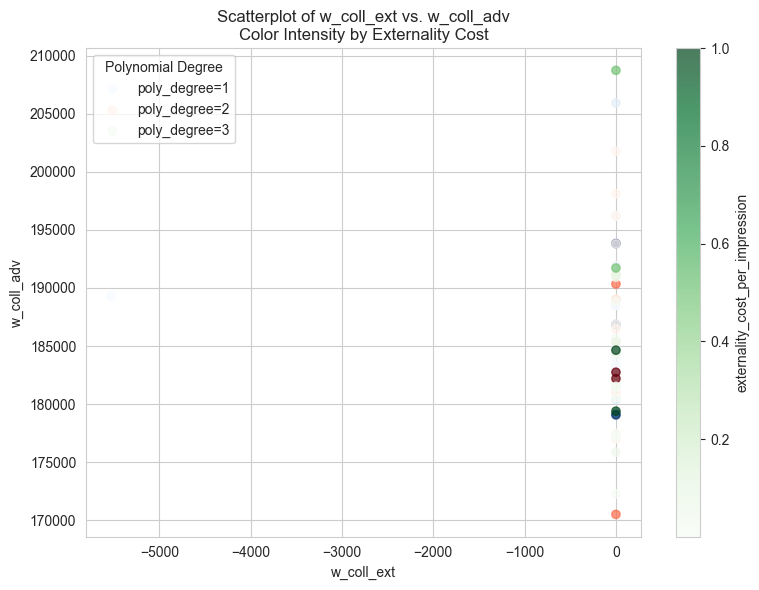

In [25]:
# Plot ad welfare vs ext welfare
df_k_1 = df[df['k'] == 1]


# Define a mapping from polynomial_degree to a named colormap
cmap_dict = {
    1: 'Blues',
    2: 'Reds',
    3: 'Greens'
}


plt.figure(figsize=(8,6))
# We will keep track of the min and max of externality_cost_per_impression
# so that each scatter uses the same color scale
vmin = df['externality_cost_per_impression'].min()
vmax = df['externality_cost_per_impression'].max()

for poly in [1, 2, 3]:
    subset = df_k_1[df_k_1['polynomial_degree'] == poly]
    
    # Plot each subset with its own colormap
    scatter = plt.scatter(
        x=subset['w_coll_ext'],
        y=subset['w_coll_adv'],
        c=subset['externality_cost_per_impression'],
        cmap=cmap_dict[poly],
        alpha=0.7,  # slightly transparent
        vmin=vmin,  # ensures consistent color scale across subsets
        vmax=vmax,
        label=f'poly_degree={poly}'
    )
# A single colorbar for all points
cbar = plt.colorbar(scatter, label='externality_cost_per_impression')

plt.xlabel('w_coll_ext')
plt.ylabel('w_coll_adv')
plt.title('Scatterplot of w_coll_ext vs. w_coll_adv\nColor Intensity by Externality Cost')
plt.legend(title='Polynomial Degree')
plt.tight_layout()
plt.show()

In [5]:
print(df.columns)

Index(['externality_cost_per_impression', 'num_advertisers', 'num_auctions',
       'random_seed', 'k', 'polynomial_degree', 'replication', 'tau',
       'w_vcg_adv', 'w_coll_adv', 'w_vcg_ext', 'w_coll_ext', 'w_vcg_tot',
       'w_coll_tot'],
      dtype='object')


In [24]:
df['w_adv_change'] = df['w_coll_adv'] - df['w_vcg_adv']
df['w_ext_change'] = df['w_coll_ext'] - df['w_vcg_ext']
df['w_tot_change'] = df['w_coll_tot'] - df['w_vcg_tot']

print(df[['w_adv_change', 'w_ext_change', 'w_tot_change']].describe())

       w_adv_change  w_ext_change  w_tot_change
count    162.000000    162.000000    162.000000
mean      -1.004171      1.813981      0.809811
std       12.781007     23.088212     10.307205
min     -162.675659      0.000000      0.000000
25%        0.000000      0.000000      0.000000
50%        0.000000      0.000000      0.000000
75%        0.000000      0.000000      0.000000
max        0.000000    293.864966    131.189308
